--- 1. Loading & Splitting Data ---
--- 2. Generating SMOTE Data for Experiments ---
Original Train: 5616 | SMOTE Train: 8222

--- 3. Loading Saved Models ---
✅ Loaded: DT Baseline
✅ Loaded: DT Tuned
✅ Loaded: NN Baseline
✅ Loaded: NN Tuned

--- 4. Training SMOTE Experimental Models ---
✅ Trained: DT Tuned + SMOTE
✅ Trained: NN Tuned + SMOTE

--- 5. Evaluating All 6 Models ---

===  FINAL MODEL LEADERBOARD ===


,Model,Accuracy,Recall (Catching Churn),AUC Score
3,4. NN Baseline,0.792171,0.502841,0.837475
4,5. NN Tuned,0.794306,0.460227,0.834464
0,1. DT Baseline,0.787189,0.460227,0.827730
2,3. DT Tuned + SMOTE,0.735231,0.772727,0.822999
5,6. NN Tuned + SMOTE,0.730249,0.758523,0.820634
1,2. DT Tuned,0.776512,0.573864,0.814973


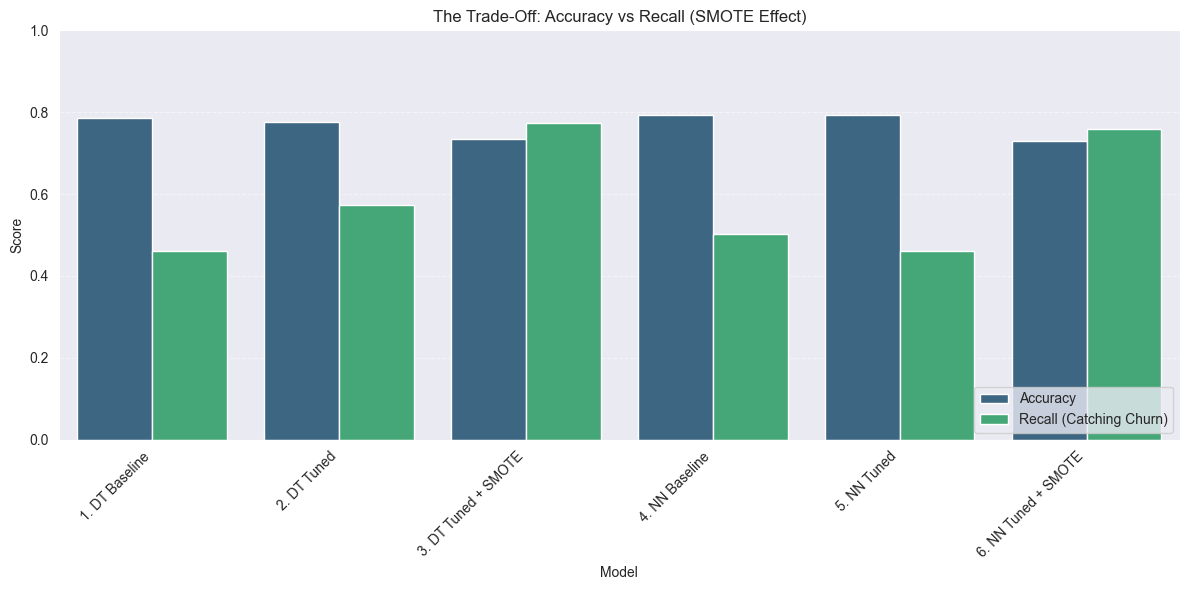

--------------------------------------------------
CONSULTANT'S VERDICT:
★ Best Overall Model (Balanced): 4. NN Baseline
   (AUC: 0.8375 | Acc: 0.7922)
   Reason: It separates loyal vs churn customers most effectively.
--------------------------------------------------
★ Best 'Safety Net' Model (Aggressive): 3. DT Tuned + SMOTE
   (Recall: 0.7727)
   Reason: It catches the most churners, though it raises more false alarms.
--------------------------------------------------


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

import warnings
warnings.filterwarnings('ignore')

# 1.(Data Loading)
print("--- 1. Loading & Splitting Data ---")
df = pd.read_csv('../data/telco_churn_processed.csv')
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create SMOTE Data
print("--- 2. Generating SMOTE Data for Experiments ---")
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print(f"Original Train: {len(X_train)} | SMOTE Train: {len(X_train_smote)}")

# List to store results
leaderboard = []

# 2. LOAD SAVED MODELS
print("\n--- 3. Loading Saved Models ---")

# A. Load DT Baseline
try:
    dt_base = joblib.load('../models/dt_baseline.joblib')
    print("✅ Loaded: DT Baseline")
except:
    print("❌ Error loading DT Baseline. Did you run Notebook 03?")

# B. Load DT Tuned
try:
    dt_tuned = joblib.load('../models/dt_tuned.joblib')
    print("✅ Loaded: DT Tuned")
except:
    print("❌ Error loading DT Tuned. Did you run Notebook 04?")

# C. Load NN Baseline
try:
    nn_base = load_model('../models/telco_churn_nn_model.keras')
    print("✅ Loaded: NN Baseline")
except:
    print("❌ Error loading NN Baseline")

# D. Load NN Tuned
try:
    nn_tuned = load_model('../models/nn_tuned_model.keras')
    print("✅ Loaded: NN Tuned")
except:
    print("❌ Error loading NN Tuned")

# 3. TRAIN EXPERIMENTAL MODELS (SMOTE)
print("\n--- 4. Training SMOTE Experimental Models ---")

# E. DT Tuned + SMOTE
dt_smote = DecisionTreeClassifier(max_depth=7, criterion='entropy', min_samples_split=2, random_state=42)
dt_smote.fit(X_train_smote, y_train_smote)
print("✅ Trained: DT Tuned + SMOTE")

# F. NN Tuned + SMOTE
nn_smote = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_smote.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
nn_smote.fit(X_train_smote, y_train_smote, epochs=50, batch_size=32, verbose=0)
print("✅ Trained: NN Tuned + SMOTE")

# 4. THE EVALUATION
print("\n--- 5. Evaluating All 6 Models ---")

models_dict = {
    "1. DT Baseline": dt_base,
    "2. DT Tuned": dt_tuned,
    "3. DT Tuned + SMOTE": dt_smote,
    "4. NN Baseline": nn_base,
    "5. NN Tuned": nn_tuned,
    "6. NN Tuned + SMOTE": nn_smote
}

for name, model in models_dict.items():
    # Predict
    if "NN" in name:
        # Neural Networks give probabilities, convert to 0/1
        y_probs = model.predict(X_test, verbose=0).ravel()
        y_pred = (y_probs > 0.5).astype("int32")
    else:
        # Decision Trees give 0/1 directly
        y_pred = model.predict(X_test)
        y_probs = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)

    leaderboard.append({
        "Model": name,
        "Accuracy": acc,
        "Recall (Catching Churn)": recall,
        "AUC Score": auc
    })


# 5. FINAL RESULTS
results_df = pd.DataFrame(leaderboard)

# Display Table
print("\n===  FINAL MODEL LEADERBOARD ===")
display(results_df.sort_values(by="AUC Score", ascending=False).style.background_gradient(cmap='Greens'))

# 6. VISUALIZATION
# Melt for plotting
plot_data = results_df.melt(id_vars="Model", value_vars=["Accuracy", "Recall (Catching Churn)"], var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("The Trade-Off: Accuracy vs Recall (SMOTE Effect)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 7. CONSULTANT'S VERDICT
best_auc = results_df.loc[results_df['AUC Score'].idxmax()]
best_recall = results_df.loc[results_df['Recall (Catching Churn)'].idxmax()]

print("-" * 50)
print(f"CONSULTANT'S VERDICT:")
print(f"★ Best Overall Model (Balanced): {best_auc['Model']}")
print(f"   (AUC: {best_auc['AUC Score']:.4f} | Acc: {best_auc['Accuracy']:.4f})")
print(f"   Reason: It separates loyal vs churn customers most effectively.")
print("-" * 50)
print(f"★ Best 'Safety Net' Model (Aggressive): {best_recall['Model']}")
print(f"   (Recall: {best_recall['Recall (Catching Churn)']:.4f})")
print(f"   Reason: It catches the most churners, though it raises more false alarms.")
print("-" * 50)